In [13]:
#!pip install torchmetrics
#!pip install pytorch_lightning
#!pip install monai
#!pip install seaborn
#!pip install fastai
#!pip install opencv-python
#!pip install openpyxl
#!pip install tabulate

In [14]:
import os
wd_path = '/teamspace/studios/this_studio/.lightning_studio/'

os.chdir(wd_path)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as v2
import torchmetrics

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from create_dataframe import create_dataframe # Added new import for reading in pd dataframe
from data_rev2 import CustomDataset
from models import ClassifierModel
from trivial_augment import TrivialAugment, get_augmentation_set
from training import train_model

## Configuration

Put all the directories and other parameters here that will be the same across experiments.

In [15]:
all_data = create_dataframe(wd_path)
train_df = all_data[all_data['split'] == 'train']
val_df = all_data[all_data['split'] == 'val']
test_df = all_data[all_data['split'] == 'test']
display(all_data)

,dataset,image,mask,tumor,external_id,grouped_ids,split
0,BUSIS,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/BUSIS/Original/case1.png,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/BUSIS/GT/case1_GT.bmp,benign,1,BUSIS_1,train
1,BUSIS,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/BUSIS/Original/case10.png,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/BUSIS/GT/case10_GT.bmp,benign,10,BUSIS_10,train
2,BUSIS,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/BUSIS/Original/case100.png,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/BUSIS/GT/case100_GT.bmp,benign,100,BUSIS_100,train
3,BUSIS,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/BUSIS/Original/case101.png,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/BUSIS/GT/case101_GT.bmp,benign,101,BUSIS_101,train
4,BUSIS,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/BUSIS/Original/case102.png,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/BUSIS/GT/case102_GT.bmp,benign,102,BUSIS_102,train
...,...,...,...,...,...,...,...
3769,Breast_Lesions_USG,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/Breast_Lesions_USG/Original/case252.png,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/Breast_Lesions_USG/Masks/case252_tumor.png,benign,252,Breast_Lesions_USG_252,train
3770,Breast_Lesions_USG,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/Breast_Lesions_USG/Original/case253.png,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/Breast_Lesions_USG/Masks/case253_tumor.png,benign,253,Breast_Lesions_USG_253,train
3771,Breast_Lesions_USG,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/Breast_Lesions_USG/Original/case254.png,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/Breast_Lesions_USG/Masks/case254_tumor.png,malignant,254,Breast_Lesions_USG_254,train
3772,Breast_Lesions_USG,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/Breast_Lesions_USG/Original/case255.png,/teamspace/studios/this_studio/.lightning_studio/BUS Project Home/Datasets/Breast_Lesions_USG/Masks/case255_tumor.png,malignant,255,Breast_Lesions_USG_255,val


In [16]:
# Group the dataframe by 'dataset' and 'tumor' columns and count the rows in each group
counts = all_data.groupby(['dataset', 'tumor']).size().reset_index(name='counts')
total_counts = counts['counts'].sum()

# Print the counts
print("Counts by dataset and tumor:")
print(counts)
print("\nTotal counts:", total_counts)

Counts by dataset and tumor:
                 dataset      tumor  counts
0                 BUSBRA     benign    1268
1                 BUSBRA  malignant     607
2                  BUSIS     benign     306
3                  BUSIS  malignant     256
4          BUS_Dataset_B     benign     109
5          BUS_Dataset_B  malignant      54
6     Breast_Lesions_USG     benign     154
7     Breast_Lesions_USG  malignant      98
8   Dataset_BUSI_with_GT     benign     437
9   Dataset_BUSI_with_GT  malignant     210
10          Mayo_Dataset     benign     144
11          Mayo_Dataset  malignant     131

Total counts: 3774


## Experiment Parameters

Note that if `target_size=None`, the image returned by `CustomDataset` won't be resized, and resizing and cropping will need to be handled by the augmentation transforms. This might be desirable if one wanted to avoid padding in favor of center cropping, for example.  

In [17]:
# model choice
model_choice = 'EfficientNetB3'
num_classes = 2


# image parameters
target_size = 256 #(192,256) target_size for fused images, set to None to handle resizing with transforms
#target_size = 224
hist_eq = False
fusion_type = 'InputG'

# transform parameters
imsize = 256 #320 # size produced by resizing and center cropping in transforms
mean = [0.5]
std = [0.5]
use_random_aug = True

# Training and validation loop
num_epochs = 50
use_mixup = True
batch_size = 16

# Designate a path to save the model to (not working - RuntimeError: Error(s) in loading state_dict for ClassifierModel: Missing key(s) in state_dict:)
# model_save_path = wd_path + fusion_type
# print(model_save_path)


## Set up augmentation transforms, datasets, and loaders

Includes various approaches for using grayscale ultrasound and mask together to produce an input for the model.

In [18]:
# Define the additional transformations

if use_random_aug: # choose 3 random transformations for each image
    num_ops = 3 # 1 through 5
    augmentation_set = get_augmentation_set("all")

    train_transforms = v2.Compose([
            v2.Resize(imsize),
            TrivialAugment(num_ops, augmentation_set),
            v2.CenterCrop(imsize), # Only makes a difference if the random crop wasn't performed
            v2.Normalize(mean,std),]
    )
    valid_transforms = v2.Compose([
            v2.Resize(imsize),
            v2.CenterCrop(imsize),
            v2.Normalize(mean,std),]
    )
else:

    train_transforms = v2.Compose([
        v2.RandomHorizontalFlip(),  # Random horizontal flip for augmentation
        v2.RandomCrop(target_size,padding=28,padding_mode='reflect'),
        v2.RandomRotation(30),      # Random rotation for augmentation
        v2.Normalize(mean,std)
    ])

    valid_transforms = v2.Compose([
        v2.Normalize(mean,std)
    ])

# Create training and validation datasets
train_dataset = CustomDataset(train_df,
                              fusion_mode = fusion_type,
                              target_size = target_size,
                              hist_eq = hist_eq,
                              transform=train_transforms
                             )
val_dataset = CustomDataset(val_df,
                            fusion_mode = fusion_type,
                            target_size = target_size,
                            hist_eq = hist_eq,
                            transform=valid_transforms
                            )

# Create training and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Set up the model and train it

Define the transformations, create CustomDataset objects for training and validation images, and create Pytorch data loaders.

Then, initialize a ClassifierModel (pre-trained resnet18) and define the loss function and optimizer.

In [19]:
model = ClassifierModel(num_classes=num_classes, model_choice=model_choice)

loss_function = nn.CrossEntropyLoss()

metrics = {
    'accuracy': torchmetrics.Accuracy(num_classes=num_classes, task='multiclass'),
    'precision': torchmetrics.Precision(num_classes=num_classes, average='macro', task='multiclass'),
    'recall': torchmetrics.Recall(num_classes=num_classes, average='macro', task='multiclass'),
    'auroc': torchmetrics.AUROC(num_classes=num_classes, task='multiclass'),
}

results_df = train_model(model, loss_function,
                         epochs = num_epochs,
                         use_mixup = use_mixup,
                         metrics = metrics,
                         train_loader = train_loader,
                         val_loader = val_loader,
                         save_model_filename = False)

# Save the model to the wd
torch.save(model.state_dict(), f'{fusion_type}_weights2.pth')
results_df.to_csv(f'{fusion_type}_results_df2.csv')

Epoch 6/50, Training 30.12% complete, Validation 0.00% complete lr = 1.000e-03
 Epoch  train_loss  val_accuracy  val_auroc  val_loss  val_precision  val_recall      Time    LR
     1    0.602996      0.801786   0.723267  0.444029       0.737718    0.718494 73.988083 0.001
     2    0.572170      0.855357   0.774105  0.386148       0.788957    0.782053 73.963281 0.001
     3    0.540466      0.844643   0.788127  0.358560       0.804183    0.773506 73.177108 0.001
     4    0.534764      0.851786   0.771777  0.377181       0.757476    0.760075 74.222064 0.001
     5    0.540424      0.839286   0.777910  0.386366       0.773018    0.779067 73.224059 0.001


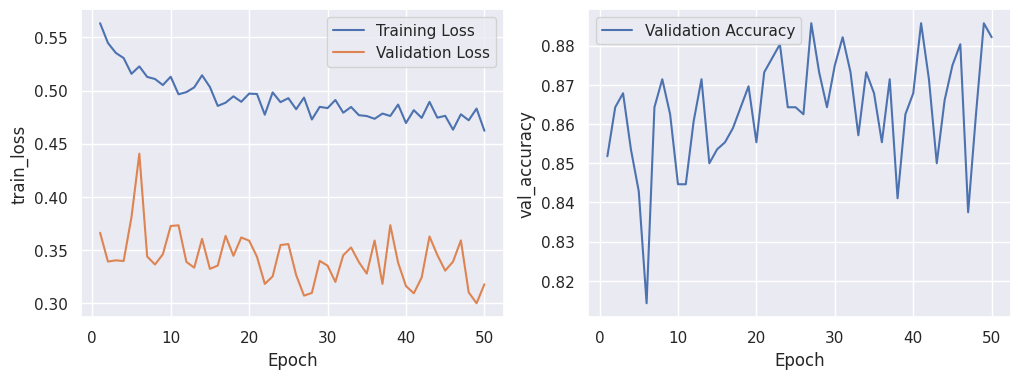

In [ ]:
def plot_results(df, use_mixup):
    fig,ax = plt.subplots(1,2,figsize=(12,4))
    sns.lineplot(x='Epoch',y='train_loss',data=df,label='Training Loss',ax=ax[0]);
    sns.lineplot(x='Epoch',y='val_loss',data=df,label='Validation Loss',ax=ax[0]);
    if not use_mixup:
        sns.lineplot(x='Epoch',y='train_accuracy',data=df,label='Training Accuracy',ax=ax[1]);
    sns.lineplot(x='Epoch',y='val_accuracy',data=df,label='Validation Accuracy',ax=ax[1]);

plot_results(results_df,use_mixup)

In [ ]:
# Use the trained model to make predictions

def get_predictions(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for final_image, label, external_id, pathology in data_loader:
            output = model(final_image)
            pred = output.argmax(dim=1)
            predictions.extend(pred.tolist()) # flattened list of integers
            actual_labels.extend(label.tolist()) # flattened list of integers

    return predictions, actual_labels

test_dataset = CustomDataset(test_df,
                              fusion_mode = fusion_type,
                              target_size = target_size,
                              hist_eq = hist_eq,
                              transform=train_transforms
                             )

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get predictions and actual labels for the test set
predictions, actual_labels = get_predictions(model, test_loader)
actual_and_preds = pd.DataFrame({'Actual': actual_labels, 'Predictions': predictions})

# Output the predictions
actual_and_preds.to_csv(f'{fusion_type}_Predictions2.csv')


In [ ]:
# Generate the classification report
report = classification_report(actual_labels, predictions)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       362
           1       0.84      0.65      0.73       204

    accuracy                           0.83       566
   macro avg       0.83      0.79      0.81       566
weighted avg       0.83      0.83      0.82       566



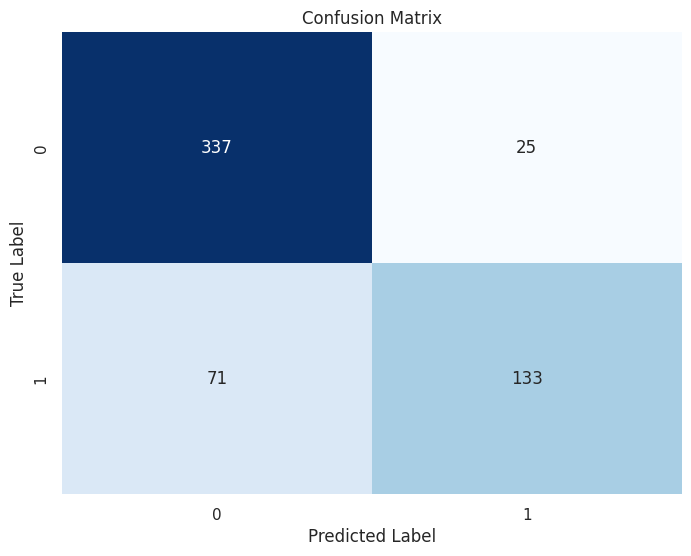

In [ ]:
# Create and display a confusion matrix
cm = confusion_matrix(actual_labels, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
